Three parts:

1. Basic spectral extraction using aperture photometry.
2. Wavelength calibration
3. Spectral line profile analysis

In [1]:
from astropy.io import fits
import lmfit
import matplotlib.pyplot as plt

%matplotlib widget  

## Step 0: visualize the Helium and NeAr calibration data

In [2]:
HeFN = './heliumwavecal.fit'
NeAr = './alphacasswavecal.fit'

imHe = fits.getdata(HeFN)[2000:4000, :]
imNeAr = fits.getdata(NeAr)[2000:4000, :]
plt.close('all')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
ax1.imshow(imHe, origin='lower', vmin=0, vmax=40)
ax2.imshow(imNeAr, origin='lower', vmin=0, vmax=400)

for ax in [ax1, ax2]:
    ax.set_xlim([3500, 8500])
    ax.set_xlabel('X [pixels]')
    ax.set_ylabel('Y [pixels]')


FileNotFoundError: [Errno 2] No such file or directory: './heliumwavecal.fit'

Text(0, 0.5, 'Raw flux [ADU]')

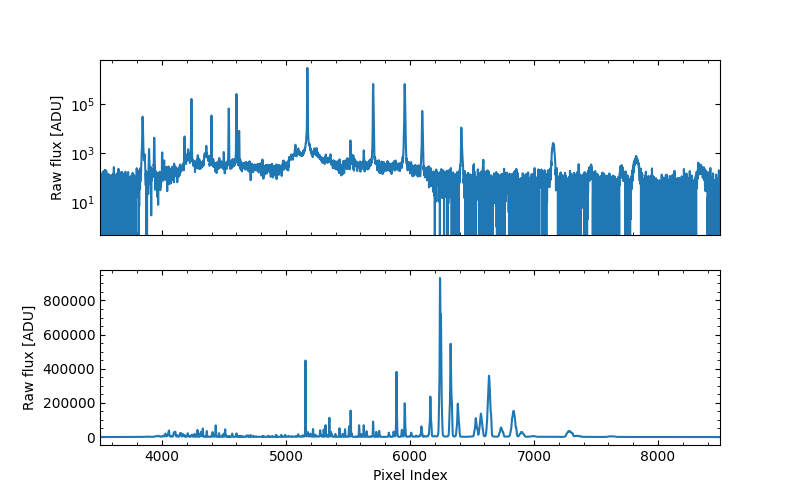

In [66]:
import numpy as np
# assume no wavelength dependence in sky background
background_He = np.median(imHe[0:500, :])
background_NeAr = np.median(imNeAr[0:500, :])

rawSpec_He = ((imHe - background_He)[1000:1100, :]).sum(axis=0)
rawSpec_NeAr = ((imNeAr - background_NeAr)[1000:1100, :]).sum(axis=0)
wl_index = np.arange(imHe.shape[1])

fig, (ax1, ax2) = plt.subplots(figsize=(8, 5), nrows=2, ncols=1, sharex=True)

ax1.plot(wl_index, rawSpec_He)
ax1.set_yscale('log')
ax2.plot(wl_index, rawSpec_NeAr)
# ax2.set_yscale('log')

for ax in [ax1, ax2]:
    ax.set_xlim([3500, 8500])

ax2.set_xlabel('Pixel Index')
ax1.set_ylabel('Raw flux [ADU]')
ax2.set_ylabel('Raw flux [ADU]')


# Establish a rough wavelength solution:

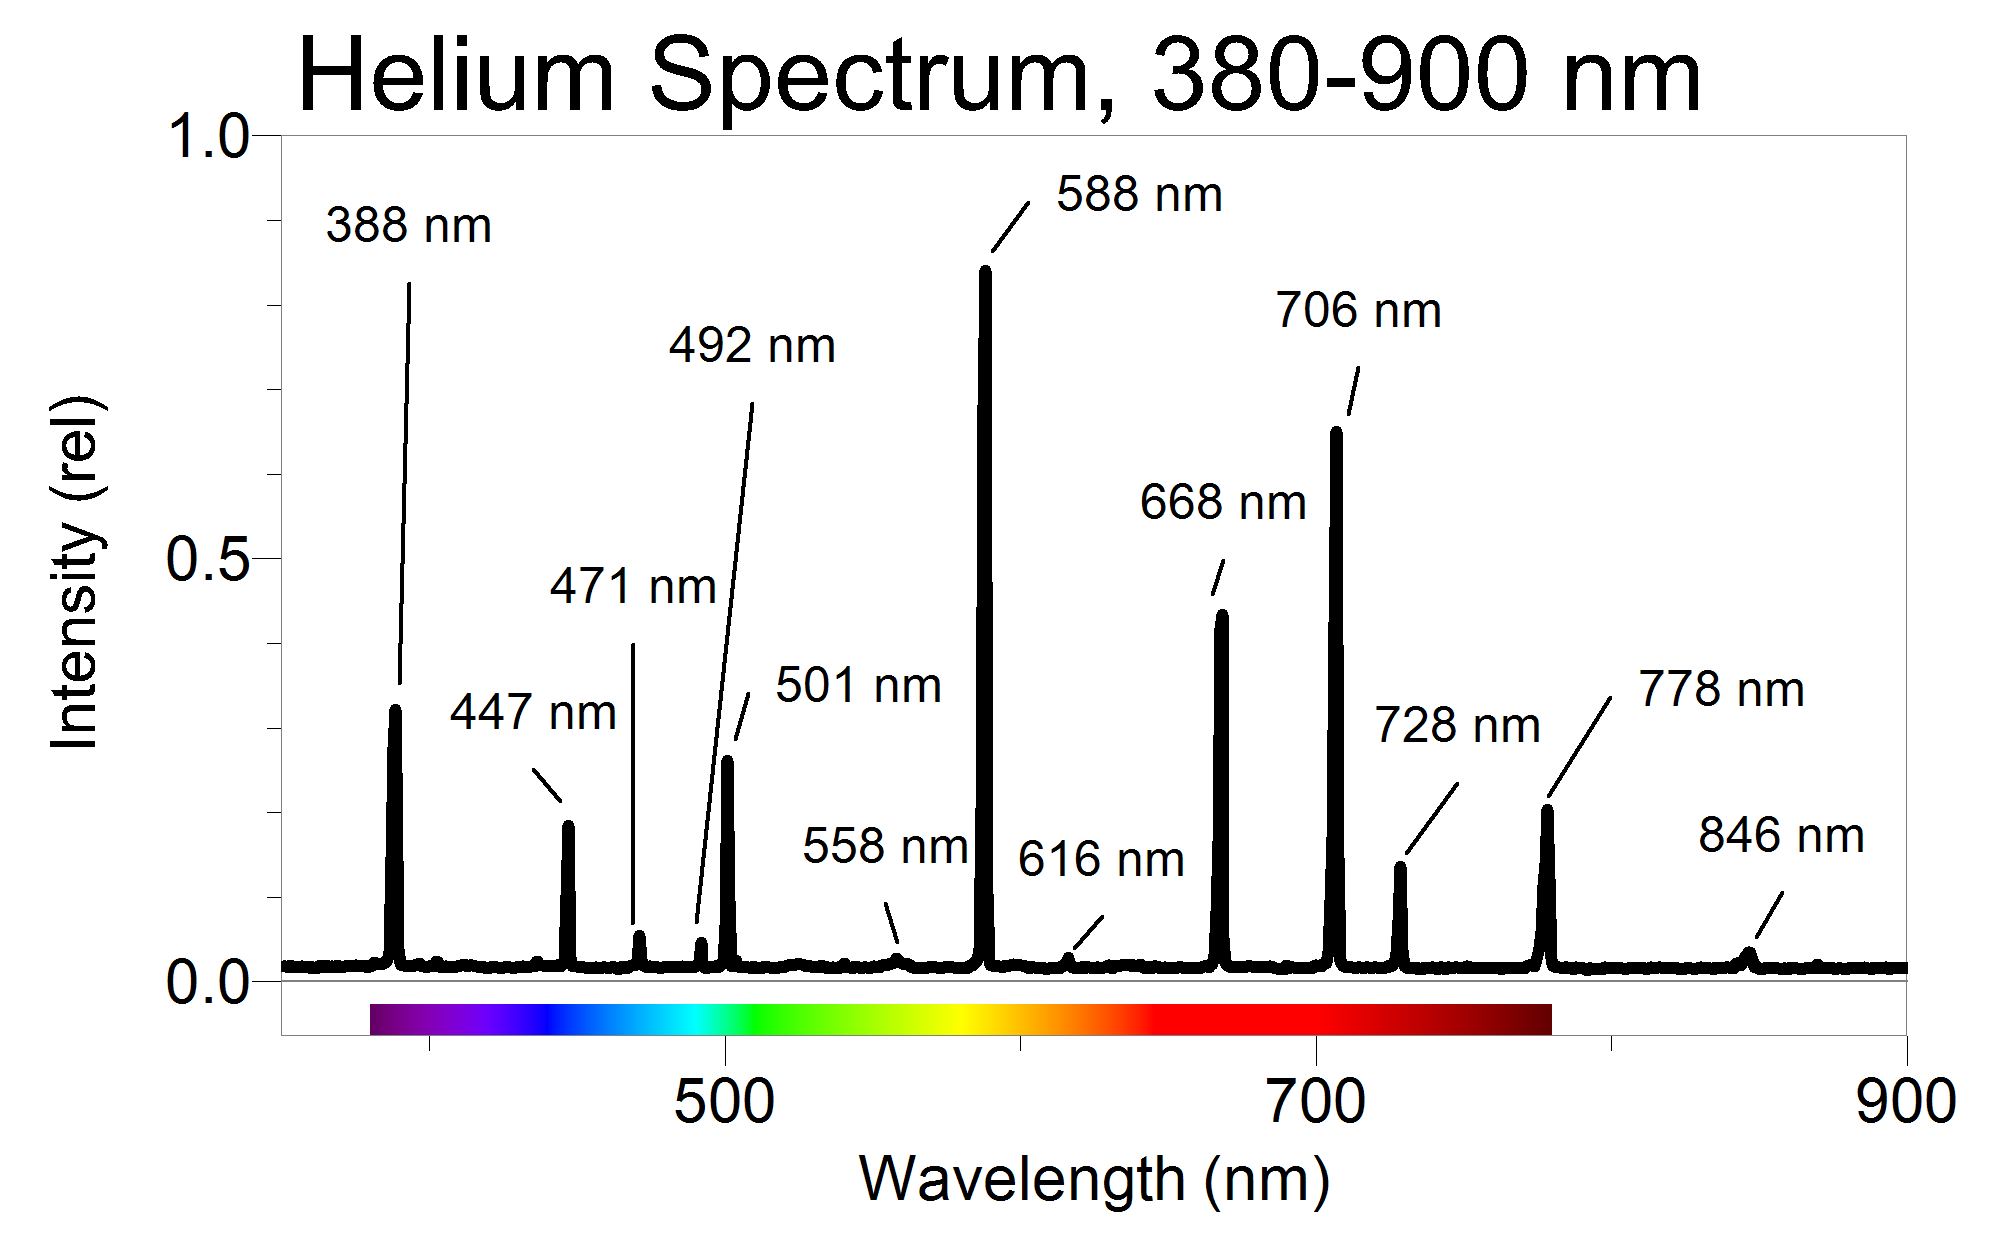


Text(0, 0.5, 'Wavelengths [Angstrom]')

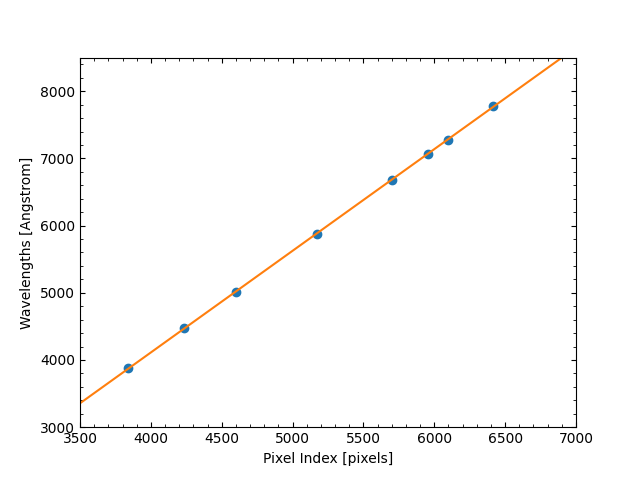

In [35]:
lineList = np.array([3880, 4470, 5010, 5880, 6680, 7060, 7280, 7780])
xList = np.array([3840, 4236, 4599, 5170, 5701, 5955, 6097, 6412])

def linear_fit(x, y):
    """
    Perform an analytical solution to fit y = mx + b.

    Parameters:
    x (array-like): Independent variable.
    y (array-like): Dependent variable.

    Returns:
    tuple: Slope (m) and intercept (b).
    """
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xx = np.sum(x * x)
    sum_xy = np.sum(x * y)

    m = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x**2)
    b = (sum_y - m * sum_x) / n

    return m, b

m_wavecal, b_wavecal = linear_fit(xList, lineList)
wl = m_wavecal * wl_index + b_wavecal
plt.figure()
plt.plot(xList, lineList, 'o')
plt.plot(wl_index, wl)
plt.xlim([3500, 7000])
plt.ylim([3000, 8500])
plt.xlabel('Pixel Index [pixels]')
plt.ylabel('Wavelengths [Angstrom]')

# extract stellar spectrum

(3500.0, 8500.0)

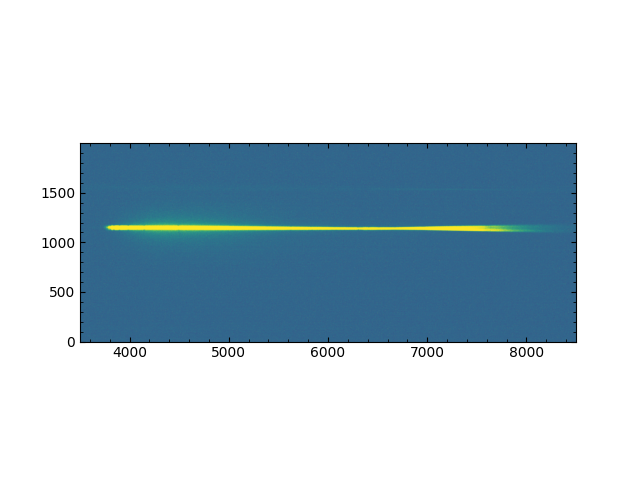

In [39]:
import glob

stellarSpecFNList = glob.glob('./alphapeg*.fit')
imList = []
for fn in stellarSpecFNList:
    specIm = fits.getdata(fn)[2000:4000, :]
    imList.append(specIm)
imShape = imList[0].shape
imCube = np.zeros((3, imShape[0], imShape[1]))
imCube[0] = imList[0]
imCube[1] = imList[1]
imCube[2] = imList[2]
imMedian = np.median(imCube, axis=0)
fig, ax = plt.subplots()
ax.imshow(imMedian, origin='lower', vmin=0, vmax=40)
ax.set_xlim([3500, 8500])

Text(0, 0.5, 'Flux [ADU]')

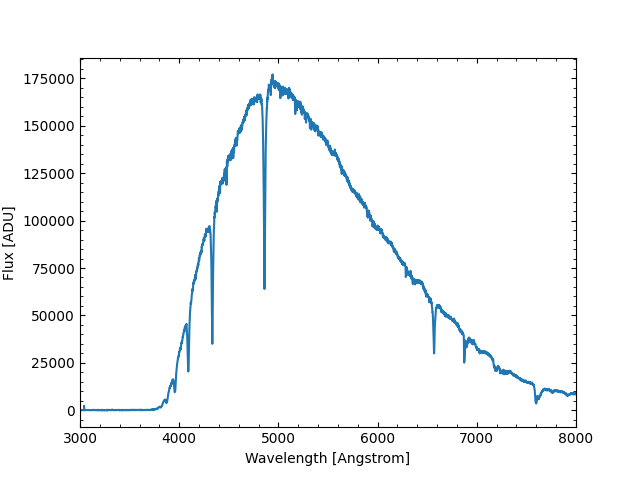

In [67]:
# extract the spectrum

sky = np.median(imMedian[0:500, :])
spec = ((imMedian-sky)[1050:1250, :]).sum(axis=0)

fig, ax = plt.subplots()
plt.plot(wl, spec)
plt.xlim([3000, 8000])
ax.set_xlabel('Wavelength [Angstrom]')
ax.set_ylabel('Flux [ADU]')

(4000.0, 8000.0)

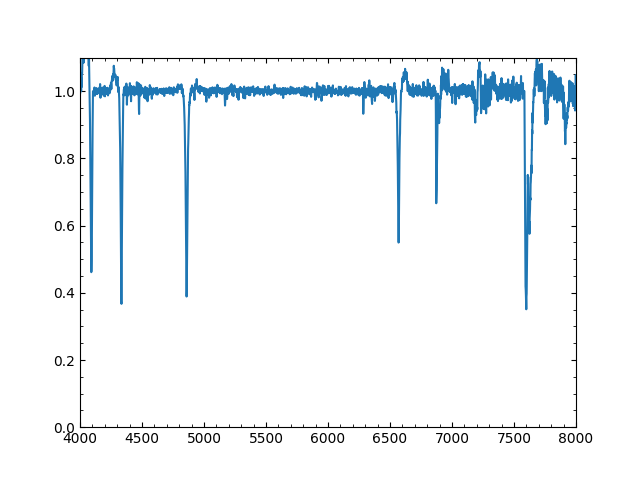

In [68]:
# find the continuum
from scipy.ndimage import median_filter

spec_smooth = median_filter(spec, 101)
plt.figure()
# plt.plot(wl, spec)
# plt.plot(wl, spec_smooth)
plt.plot(wl, spec/spec_smooth)
plt.ylim([0, 1.1])
plt.xlim([4000, 8000])

(0.0, 200000.0)

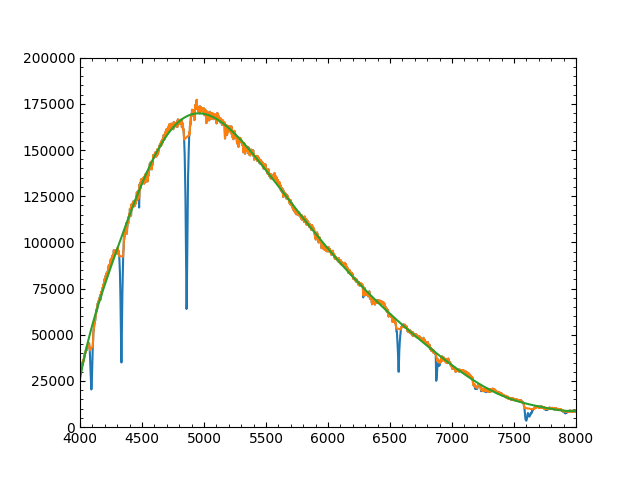

In [ ]:
spec_masked = spec[(spec/spec_smooth > 0.99) & (wl > 4000) & (wl < 8000)]
wl_masked = wl[(spec / spec_smooth > 0.99) & (wl > 4000) & (wl < 8000)]

# Fit 2nd order polynomial
coeffs = np.polyfit(wl_masked, spec_masked, 17)

# Evaluate fit
continuum_fit = np.polyval(coeffs, wl)

plt.figure()
plt.plot(wl, spec)
plt.plot(wl_masked, spec_masked)
plt.plot(wl, continuum_fit)
plt.xlim([4000, 8000])
plt.ylim([0, 200000])

(0.0, 1.1)

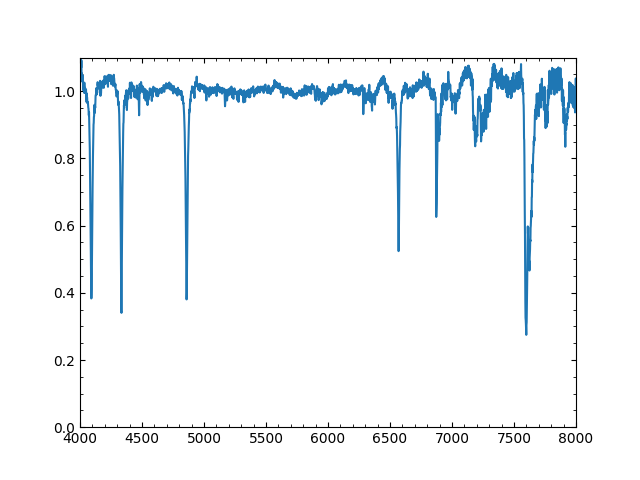

In [70]:
# obtain normalized spec
spec_normed = spec / continuum_fit
plt.figure()
plt.plot(wl, spec_normed)
plt.xlim([4000, 8000])
plt.ylim([0, 1.1])

[[Model]]
    (Model(constant) - Model(gaussian))
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 188
    # data points      = 231
    # variables        = 4
    chi-square         = 0.11127625
    reduced chi-square = 4.9020e-04
    Akaike info crit   = -1756.41431
    Bayesian info crit = -1742.64463
    R-squared          = 0.93199546
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    c:          1.00345030 (init = 1)
    amplitude:  8.87487020 (init = 0.5)
    center:     6569.08025 (init = 6568)
    sigma:      8.77395496 (init = 1)
    fwhm:       20.6610846 == '2.3548200*sigma'
    height:     0.40353081 == '0.3989423*amplitude/max(1e-15, sigma)'
[[Model]]
    (Model(constant) - Model(lorentzian))
[[Fit Statist

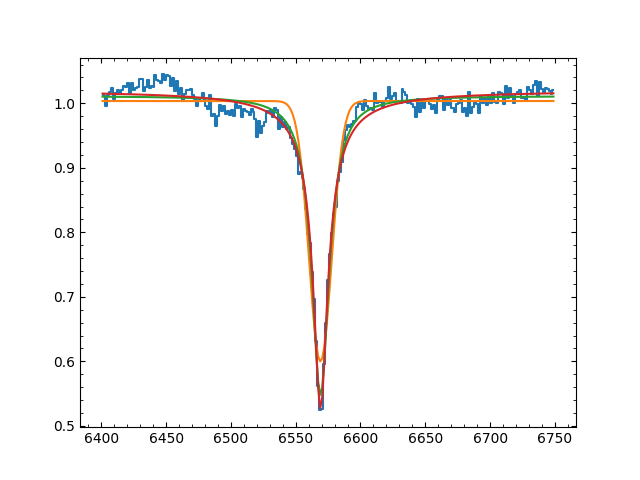

In [72]:
import numpy as np
from lmfit.models import GaussianModel, LorentzianModel, ConstantModel, MoffatModel

# check the h-alpha line

wl_halpha = wl[(wl>6400) & (wl<6750)]
spec_halpha = spec_normed[(wl>6400) & (wl<6750)]
# Gaussian fit
gauss = ConstantModel() - GaussianModel()
params_g = gauss.make_params(
    c=1,  # continuum level
    amplitude=0.5,  # absorption depth
    center=6568,
    sigma=1
)

result_g = gauss.fit(spec_halpha, params_g, x=wl_halpha, method='powell')
print(result_g.fit_report())

# Lorentzian fit
lorentz = ConstantModel() - LorentzianModel()

params_l = lorentz.make_params(
    c=1,  # continuum level
    amplitude=0.5,  # absorption depth
    center=6568,
    sigma=1
)
result_l = lorentz.fit(spec_halpha, params_l, x=wl_halpha, method='powell')
print(result_l.fit_report())

moffat = ConstantModel() - MoffatModel()

params_m = moffat.make_params(
    c=1,
    amplitude=0.5,
    center=6568,
    sigma=1
)

result_m = moffat.fit(spec_halpha, params_m, x=wl_halpha, method='powell')
print(result_m.fit_report())

plt.figure()
plt.plot(wl_halpha, spec_halpha, ds='steps-mid')
plt.plot(wl_halpha, result_g.best_fit)
plt.plot(wl_halpha, result_l.best_fit)
plt.plot(wl_halpha, result_m.best_fit)

In [57]:
params_g

name,value,initial value,min,max,vary,expression
amplitude,271.700915,271.7009148821307,-inf,inf,True,
center,6575.23591,6575.235908282216,-inf,inf,True,
sigma,173.967713,173.96771309843461,0.00000000,inf,True,
fwhm,409.662650,None,-inf,inf,False,2.3548200*sigma
height,0.62306382,None,-inf,inf,False,"0.3989423*amplitude/max(1e-15, sigma)"
